# FBXL4


In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.6.0


# FBXL4
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for FBXL4.

In [2]:
gene_symbol = 'FBXL4'
mane_tx_id = 'NM_001278716.2'
mane_protein_id = 'NP_001265645.1' # F-box/LRR-repeat protein 4

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.20") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f"Extracted {len(phenopackets)} phenopackets for {gene_symbol}")


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Extracted 95 phenopackets for FBXL4
Individuals Processed: 100%|██████████| 95/95 [01:09<00:00,  1.36individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #0
    diseases
      #0
       warnings:

  patient #1
    diseases
      #0
       warnings:

  patient #2
    diseases
      #0
       warnings:

  patient #4
    diseases
      #0
       warnings:

  patient #7
    diseases
      #0
       warnings:

  patient #8
    diseases
      #0
       warnings:

  patient #9
    diseases
      #0
       warnings:

  patient #11
    diseases
      #0
       warnings:

  patient #13
    diseases
      #0
       warnings:

  patient #15
    diseases
      #0
       warnings:

  patient #16
    diseases
      #0
       warnings:

  patient #18
    diseases
      #0
       warnings:

  patient #20
    diseases
      #0
       warnings:

  patient #21
    diseases
      #0
       warnings:

  patient #22
    diseases
      #0
       warnings:

  pati

In [5]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Increased serum lactate,HP:0002151,92
Hypotonia,HP:0001252,79
Global developmental delay,HP:0001263,52
Global brain atrophy,HP:0002283,39
Feeding difficulties,HP:0011968,36
Failure to thrive,HP:0001508,32
Cerebral atrophy,HP:0002059,30
Small for gestational age,HP:0001518,28
Short stature,HP:0004322,27
Microcephaly,HP:0000252,27


<Axes: title={'center': 'F-box/LRR-repeat protein 4\ntranscript: NM_001278716.2, protein: NP_001265645.1'}>

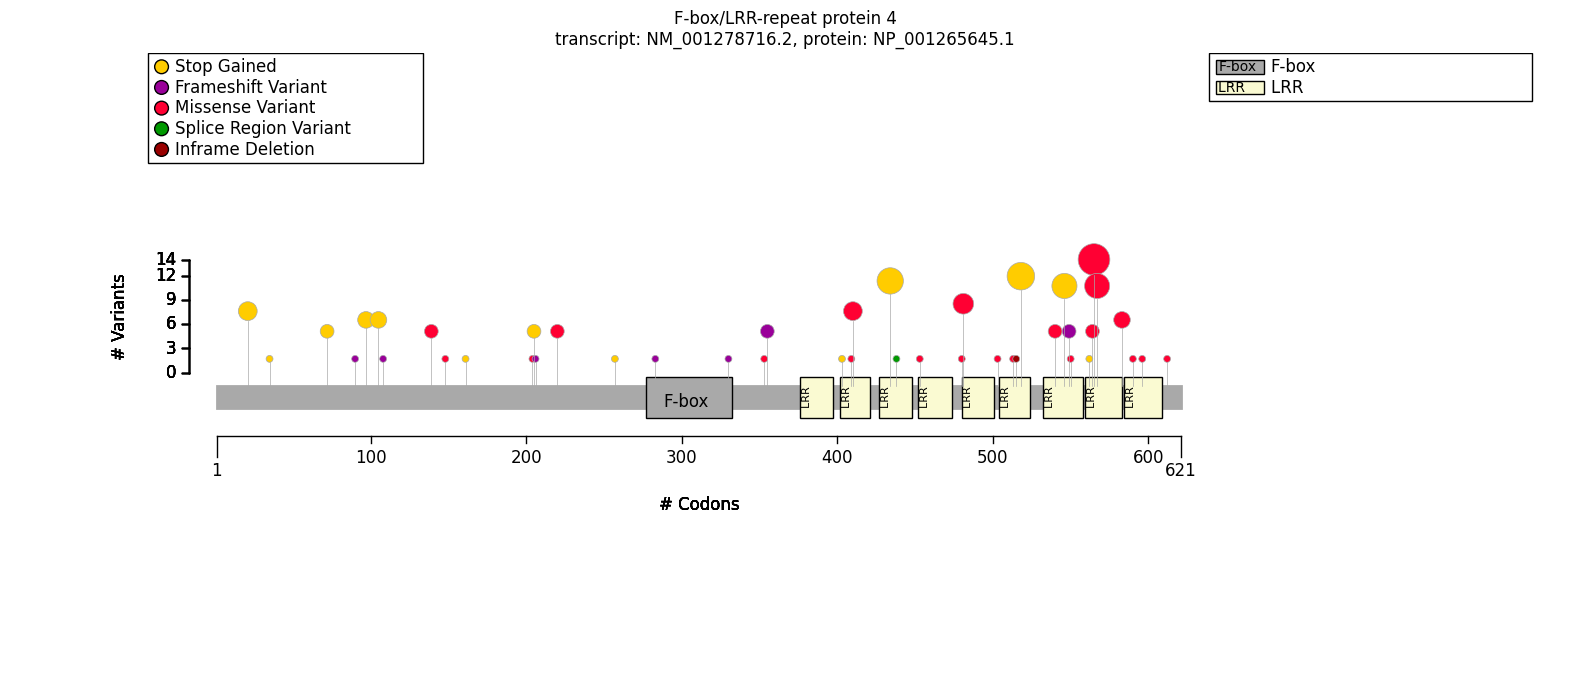

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService, configure_default_protein_metadata_service

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id) 
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
from gpsea.view import ProteinVisualizable, ProteinVisualizer

pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)

In [7]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
6_98875419_98875419_T_C,c.1698A>G,p.Ile566Met,9,missense,14
6_98875562_98875562_G_A,c.1555C>T,p.Gln519Ter,9,stop gained,10
6_98875474_98875476_TCA_T,c.1641_1642del,p.Cys547Ter,9,"stop gained, frameshift",8
6_98874441_98874441_C_G,c.1703G>C,p.Gly568Ala,10,"missense, splice region",8
6_98899282_98899282_G_A,c.1303C>T,p.Arg435Ter,7,stop gained,6
6_98875673_98875673_G_A,c.1444C>T,p.Arg482Trp,9,missense,5
6_98926925_98926925_G_A,c.64C>T,p.Arg22Ter,4,stop gained,4
6_98899353_98899353_C_T,c.1232G>A,p.Cys411Tyr,7,missense,4
6_98874394_98874394_A_G,c.1750T>C,p.Cys584Arg,10,missense,3
6_98926697_98926697_G_A,c.292C>T,p.Arg98Ter,4,stop gained,3


In [8]:
from gpsea.view import ProteinVariantViewer
pvviewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvviewer.process(cohort=cohort)

Name,Type,Coordinates,Count,Variants
F-box,DOMAIN,277 - 332,2,p.Pro284LeufsTer7; p.Leu332ThrfsTer3
LRR 1,REPEAT,376 - 397,0,
LRR 2,REPEAT,402 - 421,6,p.Cys411Tyr; p.Ser410Phe; p.Gln404Ter
LRR 3,REPEAT,427 - 448,10,p.Arg435Ter; p.Glu439=; p.Arg435Gln; p.Arg435Leu
LRR 4,REPEAT,452 - 474,1,p.Gln454Pro
LRR 5,REPEAT,480 - 501,6,p.Arg482Trp; p.Leu481Pro
LRR 6,REPEAT,504 - 524,12,p.Gln519Ter; p.Pro516_Ser521del; p.Trp514Gly
LRR 7,REPEAT,532 - 558,13,p.Asp550HisfsTer2; p.Ile551Asn; p.Cys547Ter; p.Thr541Ile
LRR 8,REPEAT,559 - 583,25,p.Ile566Met; p.Gly568Ala; p.Gln563Ter; p.Asp565Gly
LRR 9,REPEAT,584 - 609,2,p.Gln597Pro; p.Asp591Gly


In [29]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
len(pheno_predicates)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(
    hpo=hpo,
)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
     mtc_alpha=mtc_alpha,
)

In [30]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import biallelic_predicate, VariantPredicates

missense = VariantPredicates.variant_effect(effect=VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
is_missense = biallelic_predicate(a_predicate=missense, b_predicate=~missense,a_label="missense", b_label="other",
                                  partitions=((1,2), (0,)))
is_missense.display_question()

'Allele group: missense/other OR other/other, missense/missense'

In [31]:
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=is_missense,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,38
HMF03,Skipping term because of a child term with the same individual counts,4
HMF08,Skipping general term,88
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,201


In [32]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense/other OR other/other  \
                                                                           Count   
Feeding difficulties [HP:0011968]                                          23/24   
Cryptorchidism [HP:0000028]                                                 7/16   
Microcephaly [HP:0000252]                                                  20/34   
Short stature [HP:0004322]                                                 18/28   
Failure to thrive [HP:0001508]                                             21/30   
Ventriculomegaly [HP:0002119]                                              12/28   
Hyperammonemia [HP:0001987]                                                12/31   
Decreased body weight [HP:0004325]                                         28/28   
Morphological central nervous system abnormalit...                         48/48   
Abnormal cerebral morphology [HP:0002060]                                  27/27   
Abnormal brain morphology [HP:0012443]                                     43/43   
Global brain atrophy [HP:0002283]                                          22/22   
Brain atrophy [HP:0012444]                                                 35/35   
Aplasia/Hypoplasia involving the central nervou...                         39/39   
Cerebral atrophy [HP:0002059]                                              17/31   
Hypotonia [HP:0001252]                                                     45/48   
Abnormal muscle tone [HP:0003808]                                          45/45   
Small for gestational age [HP:0001518]                                     17/27   
Increased serum lactate [HP:0002151]                                       54/54   
Acidosis [HP:0001941]                                                      55/55   
Global developmental delay [HP:0001263]                                    28/28   
Abnormal axial skeleton morphology [HP:0009121]                            26/26   

Allele group                                               missense/missense  \
                                                   Percent             Count   
Feeding difficulties [HP:0011968]                      96%             13/27   
Cryptorchidism [HP:0000028]                            44%              4/30   
Microcephaly [HP:0000252]                              59%              7/24   
Short stature [HP:0004322]                             64%              9/25   
Failure to thrive [HP:0001508]                         70%             11/25   
Ventriculomegaly [HP:0002119]                          43%              5/25   
Hyperammonemia [HP:0001987]                            39%             12/22   
Decreased body weight [HP:0004325]                    100%             14/14   
Morphological central nervous system abnormalit...    100%             30/30   
Abnormal cerebral morphology [HP:0002060]             100%             20/20   
Abnormal brain morphology [HP:0012443]                100%             30/30   
Global brain atrophy [HP:0002283]                     100%             17/17   
Brain atrophy [HP:0012444]                            100%             24/24   
Aplasia/Hypoplasia involving the central nervou...    100%             29/29   
Cerebral atrophy [HP:0002059]                          55%             13/25   
Hypotonia [HP:0001252]                                 94%             34/36   
Abnormal muscle tone [HP:0003808]                     100%             34/34   
Small for gestational age [HP:0001518]                 63%             11/17   
Increased serum lactate [HP:0002151]                  100%             38/38   
Acidosis [HP:0001941]                                 100%             38/38   
Global developmental delay [HP:0001263]               100%             24/24   
Abnormal axial skeleton morphology [HP:0009121]       100%             14/14   

Allele group                                                  

In [33]:
from gpsea.model.genome import Region

nterm = VariantPredicates.region(region=Region(start=1, end=400), tx_id=mane_tx_id)

is_nterm = biallelic_predicate(a_predicate=nterm, b_predicate=~nterm,a_label="N-term", b_label="other",
                                  partitions=((0,1), (2,)))
is_nterm.display_question()

'Allele group: N-term/N-term OR N-term/other, other/other'

In [34]:
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=is_nterm,
    pheno_predicates=pheno_predicates,
)

summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group                                       N-term/N-term OR N-term/other  \
                                                                           Count   
Cryptorchidism [HP:0000028]                                                  6/8   
Feeding difficulties [HP:0011968]                                          16/16   
Neutropenia [HP:0001875]                                                    8/19   
Bilateral tonic-clonic seizure with generalized...                          5/12   
Strabismus [HP:0000486]                                                     6/14   
Cerebral atrophy [HP:0002059]                                              12/18   
Hypotonia [HP:0001252]                                                     24/24   
Ventriculomegaly [HP:0002119]                                               7/16   
Hyperammonemia [HP:0001987]                                                 6/16   
Short stature [HP:0004322]                                                 11/19   
Small for gestational age [HP:0001518]                                      9/15   
Failure to thrive [HP:0001508]                                             10/18   
Decreased body weight [HP:0004325]                                         14/14   
Morphological central nervous system abnormalit...                         24/24   
Abnormal cerebral morphology [HP:0002060]                                  16/16   
Abnormal brain morphology [HP:0012443]                                     22/22   
Global brain atrophy [HP:0002283]                                          10/10   
Brain atrophy [HP:0012444]                                                 19/19   
Aplasia/Hypoplasia involving the central nervou...                         20/20   
Abnormal muscle tone [HP:0003808]                                          24/24   
Increased serum lactate [HP:0002151]                                       28/28   
Acidosis [HP:0001941]                                                      28/28   
Global developmental delay [HP:0001263]                                    16/16   
Microcephaly [HP:0000252]                                                   9/20   
Abnormal axial skeleton morphology [HP:0009121]                            15/15   

Allele group                                               other/other  \
                                                   Percent       Count   
Cryptorchidism [HP:0000028]                            75%        5/38   
Feeding difficulties [HP:0011968]                     100%       20/35   
Neutropenia [HP:0001875]                               42%        5/51   
Bilateral tonic-clonic seizure with generalized...     42%        3/33   
Strabismus [HP:0000486]                                43%        5/38   
Cerebral atrophy [HP:0002059]                          67%       18/38   
Hypotonia [HP:0001252]                                100%       55/60   
Ventriculomegaly [HP:0002119]                          44%       10/37   
Hyperammonemia [HP:0001987]                            38%       18/37   
Short stature [HP:0004322]                             58%       16/34   
Small for gestational age [HP:0001518]                 60%       19/29   
Failure to thrive [HP:0001508]                         56%       22/37   
Decreased body weight [HP:0004325]                    100%       28/28   
Morphological central nervous system abnormalit...    100%       54/54   
Abnormal cerebral morphology [HP:0002060]             100%       31/31   
Abnormal brain morphology [HP:0012443]                100%       51/51   
Global brain atrophy [HP:0002283]                     100%       29/29   
Brain atrophy [HP:0012444]                            100%       40/40   
Aplasia/Hypoplasia involving the central nervou...    100%       48/48   
Abnormal muscle tone [HP:0003808]                     100%       55/55   
Increased serum lactate [HP:0002151]                  100%       64/64   
Acidosis [HP:0001941]        